<a href="https://www.kaggle.com/code/erkanhatipoglu/intermediate-machine-learning-course-helper?scriptVersionId=106620822" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Introduction**    <a id='introduction'></a>

This notebook is greatly inspired by [Intermediate Machine Learning (IML)](https://www.kaggle.com/learn/intermediate-machine-learning) Course by [Alexis Cook](https://www.kaggle.com/alexisbcook) at [Kaggle Learn](https://www.kaggle.com/learn/overview). Approximately all the code in this notebook is taken from Intermediate Machine Learning Course notebooks. On the other hand, all the mistakes (if any) are made by me.

This notebook is neither an alternative nor a complementary work for Intermediate Machine Learning Course. I strongly suggest to the Kaggle Learn users to take the Course and solve the exercise notebooks by themself. However, I observed that students got stuck on some parts of the Course from time to time. This notebook is intended for those students who get stuck and cannot move forward.

Intermediate Machine Learning consists of 7 chapters. In some chapters, students use the data from [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course) to learn new approaches; they even make submissions for that competition. You can find those different approaches below. You can also see how to submit your predictions using those approaches to [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course).

If you face any problems or cannot implement the code, just let me know via the comments. I will try to answer as soon as possible. Thank you for reading.

# Table of Contents
* [Introduction](#introduction)
* [Helper Functions](#functions)
* [Lesson 2 - Missing Values](#Lesson2)
    * [Lesson 2 - Missing Values Approach 1](#L2A1)
    * [Lesson 2 - Missing Values Approach 2](#L2A2)
    * [Lesson 2 - Missing Values Approach 3](#L2A3)
* [Lesson 3 - Categorical Variables](#Lesson3)
    * [Lesson 3 - Categorical Variables Approach 4](#L3A4)
    * [Lesson 3 - Categorical Variables Approach 5](#L3A5)
    * [Lesson 3 - Categorical Variables Approach 6](#L3A6)
* [Lesson 4 - Pipelines](#Lesson4)
    * [Lesson 4 - Pipelines Approach 7](#L4A7)
* [Lesson 5 - Cross-Validation](#Lesson5)
    * [Lesson 5 - Cross-Validation Approach 8](#L5A8)
* [Lesson 6 - XGBoost](#Lesson6)
    * [Lesson 6 - XGBoost Approach 9](#L6A9)
    * [Lesson 6 - XGBoost Approach 10](#L6A10)
* [Conclusion](#conclusion)
* [References](#references)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import XGBRegressor

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


# Helper functions   <a id='functions'></a>   

<div class="alert alert-block alert-info">
<b>Tip:</b> We will use some utility functions throughout the notebook. Collecting them in one place is a good idea, making the code more organized.
</div>

In [2]:
# Score function

def score_dataset(X_train, X_valid, y_train, y_valid):
    """Calculate the score for a specific approach.
    used model = RandomForestRegressor(n_estimators=100, random_state=0).

    OUTPUT: 
    mean_absolute_error: Total absolute error / n. Sum of total absolute error divided by number of samples.
    """
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

def get_score(n_estimators, X, y):
    """Return the average MAE over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    # Replace this body with your own code
    my_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', RandomForestRegressor(n_estimators=n_estimators, random_state=0))
])
    
    from sklearn.model_selection import cross_val_score

    # Multiply by -1 since sklearn calculates *negative* MAE
    scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=3,
                              scoring='neg_mean_absolute_error')

    return scores.mean()

# Predict function

def predict (df1, df2, df3, estimators=100):
    """Predict for a specific approach.
    used model = RandomForestRegressor(n_estimators=100, random_state=0).

    INPUT:
    df1: training data
    df2: target
    df3: test data
    
    OUTPUT: 
    predictions for test data
    """
    # Define and fit model
    my_model = RandomForestRegressor(n_estimators=estimators, random_state=0)
    my_model.fit(df1, df2)

    # Get test predictions
    print ("Submission data have been calculated")
    return my_model.predict(df3)

# Save function

def save_file (predictions):
    """Save submission file."""
    # Save test predictions to file
    output = pd.DataFrame({'Id': sample_submission_file.Id,
                       'SalePrice': predictions})
    output.to_csv('submission.csv', index=False)
    print ("Submission file is saved")
    
def impute_numerical(df1, df2):
    """Impute to 2 dataframes that have only numerical values."""
    num_imputer = SimpleImputer(strategy='mean')

    num_X = pd.DataFrame(num_imputer.fit_transform(df1))
    num_test = pd.DataFrame(num_imputer.transform(df2))

    # Imputation removed column names; put them back
    num_X.columns = df1.columns
    num_test.columns = df2.columns
    return num_X, num_test


def impute_categorical(df1, df2):
    """Impute to 2 dataframes that have only categorical values."""
    
    cat_imputer = SimpleImputer(strategy='most_frequent')

    cat_X = pd.DataFrame(cat_imputer.fit_transform(df1))
    cat_test = pd.DataFrame(cat_imputer.transform(df2))

    # Imputation removed column names; put them back
    cat_X.columns = df1.columns
    cat_test.columns = df2.columns
    return cat_X, cat_test

print("Functions have been loaded!")

Functions have been loaded!


**Getting the data**

In [3]:
# For displaying all the columns of the data frame
pd.set_option('display.max_columns', None)

# get data
train_data = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv', index_col='Id')

test_data = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv", index_col='Id')

sample_submission_file = pd.read_csv("/kaggle/input/home-data-for-ml-course/sample_submission.csv")

with open('/kaggle/input/home-data-for-ml-course/data_description.txt', 'r') as f:
    description = f.read() 

# Create a dictionary of scores
scores_dict = {} # will be used for storing the scores of each approach.
submission_dict = {} # will be used for storing the submission scores of each approach.

print("Data have been loaded!")

Data have been loaded!


In [4]:
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
sample_submission_file.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [7]:
print ("Shape of train data: {}".format(train_data.shape))
print ("Shape of test data: {}".format(test_data.shape))
print ("Shape of submission file: {}".format(sample_submission_file.shape))

Shape of train data: (1460, 80)
Shape of test data: (1459, 79)
Shape of submission file: (1459, 2)


In [8]:
# Data descrition
print(description)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

# **Lesson 2 - Missing Values**  <a id='Lesson2'></a>

## **Approach 1 (A1):**  <a id='L2A1'></a>
This is the most straightforward approach. We will include the numerical columns without missing values, and all the remaining columns will be dropped!

In [9]:
# Process Data

# Select target
y = train_data.SalePrice

# Just select numerical features!
X = train_data.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object'])
X_test = test_data.select_dtypes(exclude=['object']) # will be used for submision later...

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)
print ("Shapes:")
print ("X_train: {}".format(X_train.shape))
print ("X_valid: {}".format(X_valid.shape))
print ("y_train: {}".format(y_train.shape))
print ("y_valid: {}\n".format(y_valid.shape))

# Number of missing values in each column of training data
missing_val_count_by_column_train = (X_train.isnull().sum())

print('Missing value counts for numerical columns:')
print(missing_val_count_by_column_train[missing_val_count_by_column_train > 0])

Shapes:
X_train: (1168, 36)
X_valid: (292, 36)
y_train: (1168,)
y_valid: (292,)

Missing value counts for numerical columns:
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


In [10]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print ("Shapes:")
print ("reduced_X_train: {}".format(reduced_X_train.shape))
print ("reduced_X_valid: {}".format(reduced_X_valid.shape))

Shapes:
reduced_X_train: (1168, 33)
reduced_X_valid: (292, 33)


In [11]:
print("MAE from Approach 1 (Drop columns with missing values):")
scores_dict['A1'] = score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid) # Store the score in the dictioanary
print(scores_dict['A1'])

MAE from Approach 1 (Drop columns with missing values):
17837.82570776256


### Create Submission File for approach 1

While calculating MAE for approach 1, we only deal with training data. However, if we want a model to predict the test data with approach 1, we must also consider missing values in the test data.

In [12]:
# Get names of columns with missing values of training data
cols_with_missing_X = [col for col in X.columns
                     if X[col].isnull().any()]
print ("Columns with missing values in training data: {}".format(cols_with_missing_X) + "\n")

# Get names of columns with missing values of test data
cols_with_missing_X_test = [col for col in X_test.columns
                     if X_test[col].isnull().any()]
print ("Columns with missing values in test data: {}".format(cols_with_missing_X_test) + "\n")

# Combine all missing columns
cols_with_missing = list(set(cols_with_missing_X).union(set(cols_with_missing_X_test)))

print ("Columns with missing values combined: {}".format(cols_with_missing))

Columns with missing values in training data: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Columns with missing values in test data: ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']

Columns with missing values combined: ['BsmtHalfBath', 'MasVnrArea', 'BsmtFullBath', 'BsmtFinSF2', 'LotFrontage', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'GarageYrBlt']


In [13]:
# Drop missing values
X_a1 = X.drop(cols_with_missing, axis=1)
X_test_a1 = X_test.drop(cols_with_missing, axis=1)

print ("Shape of X_a1: {}".format(X_a1.shape))
print ("Shape of test_data_a1: {}".format(X_test_a1.shape))

Shape of X_a1: (1460, 25)
Shape of test_data_a1: (1459, 25)


As can be seen, while calculating MAE with Approach 1, we use 33 features. On the other hand, to send a submission with Approach 1, we use 25 features instead.

In [14]:
# Get test predictions
preds_a1 = predict(X_a1, y, X_test_a1)

# Save test predictions to file
save_file(preds_a1)

Submission data have been calculated
Submission file is saved


Score for A1 = 17688.42490

In [15]:
submission_dict['A1'] = 17688.42490

## **Approach 2 (A2):**  <a id='L2A2'></a>
Include only numerical columns and impute columns with missing values.

In [16]:
# Process Data

# Select target
y = train_data.SalePrice

# Just select numerical features!
X = train_data.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object'])
X_test = test_data.select_dtypes(exclude=['object']) # will be used for submision later...

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)
print ("Shapes:")
print ("X_train: {}".format(X_train.shape))
print ("X_valid: {}".format(X_valid.shape))
print ("y_train: {}".format(y_train.shape))
print ("y_valid: {}\n".format(y_valid.shape))

# Number of missing values in each column of training data
missing_val_count_by_column_train = (X_train.isnull().sum())
print('Missing value counts for numerical columns:')
print(missing_val_count_by_column_train[missing_val_count_by_column_train > 0])

Shapes:
X_train: (1168, 36)
X_valid: (292, 36)
y_train: (1168,)
y_valid: (292,)

Missing value counts for numerical columns:
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


In [17]:
# Imputation
imputed_X_train, imputed_X_valid = impute_numerical(X_train, X_valid)

print("MAE from Approach 2 (Imputation):")
scores_dict['A2'] = score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid) # Store the score in the dictioanary
print(scores_dict['A2'])

MAE from Approach 2 (Imputation):
18062.894611872147


### Create Submission File for approach 2

In [18]:
# Imputation 
imputed_X, imputed_X_test = impute_numerical(X, X_test)

print ("Shape of imputed_X: {}".format(imputed_X.shape))
print ("Shape of imputed_test_data: {}".format(imputed_X_test.shape))

Shape of imputed_X: (1460, 36)
Shape of imputed_test_data: (1459, 36)


In [19]:
# Get test predictions
preds_a2 = predict(imputed_X, y, imputed_X_test)

# Save test predictions to file
save_file(preds_a2)

Submission data have been calculated
Submission file is saved


Score for A2 = 16546.14937 

In [20]:
submission_dict['A2'] = 16546.14937

## **Approach 3 (A3):**  <a id='L2A3'></a>
Include only numerical columns, impute columns with missing values, plus an extension to imputation

In [21]:
# Process Data

# Select target
y = train_data.SalePrice

# Just select numerical features!
X = train_data.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object'])
X_test = test_data.select_dtypes(exclude=['object']) # will be used for submision later...

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)
print ("Shapes:")
print ("X_train: {}".format(X_train.shape))
print ("X_valid: {}".format(X_valid.shape))
print ("y_train: {}".format(y_train.shape))
print ("y_valid: {}\n".format(y_valid.shape))

# Number of missing values in each column of training data
missing_val_count_by_column_train = (X_train.isnull().sum())
print('Missing value counts for numerical columns:')
print(missing_val_count_by_column_train[missing_val_count_by_column_train > 0])

Shapes:
X_train: (1168, 36)
X_valid: (292, 36)
y_train: (1168,)
y_valid: (292,)

Missing value counts for numerical columns:
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


In [22]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation 
imputed_X_train_plus, imputed_X_valid_plus = impute_numerical(X_train_plus, X_valid_plus)

print("MAE from Approach 3 (An Extension to Imputation):")
scores_dict['A3'] = score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid) # Store the score in the dictioanary
print(scores_dict['A3'])

MAE from Approach 3 (An Extension to Imputation):
18026.217694063926


### Create Submission File for approach 3

In [23]:
# Make copy to avoid changing original data (when imputing)
X_plus = X.copy()
reduced_X_test_plus = X_test.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_plus[col + '_was_missing'] = X_plus[col].isnull()
    reduced_X_test_plus[col + '_was_missing'] = reduced_X_test_plus[col].isnull()

# Imputation 
imputed_X_plus, imputed_reduced_X_test_plus = impute_numerical(X_plus, reduced_X_test_plus)

print ("Shape of imputed_X_plus: {}".format(imputed_X_plus.shape))
print ("Shape of imputed_reduced_X_test_plus: {}".format(imputed_reduced_X_test_plus.shape))

Shape of imputed_X_plus: (1460, 47)
Shape of imputed_reduced_X_test_plus: (1459, 47)


In [24]:
# Get test predictions
preds_a3 = predict(imputed_X_plus, y, imputed_reduced_X_test_plus)

# Save test predictions to file
save_file(preds_a3)

Submission data have been calculated
Submission file is saved


Score for A3 = 16423.75248

In [25]:
submission_dict['A3'] = 16423.75248

# **Lesson 3 - Categorical Variables**  <a id='Lesson3'></a>

## **Approach 4 (A4):**  <a id='L3A4'></a>
**Most straightforward approach:** Include only numerical columns, and drop all the categorical data.

In [26]:
# Prepare data

# Separate target from predictors
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)

# Get training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
print ("Shape of X_train: {}".format(X_train.shape))
print ("Shape of X_valid: {}".format(X_valid.shape))
print ("Shape of y_train: {}".format(y_train.shape))
print ("Shape of y_valid: {}".format(y_valid.shape))

# Drop columns with missing values ()
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()] 
print()
print ("Columns with missing values in training data: {}".format(cols_with_missing) + "\n")

X_train.drop(cols_with_missing, axis=1, inplace=True)
X_valid.drop(cols_with_missing, axis=1, inplace=True)

print ("Shape of X_train after dropping missing values: {}".format(X_train.shape))
print ("Shape of X_valid after dropping missing values: {}".format(X_valid.shape))

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print()
print("Categorical variables: {}\n".format(object_cols))

drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print ("Shape of drop_X_train after dropping object values: {}".format(drop_X_train.shape))
print ("Shape of drop_X_valid after dropping object values: {}".format(drop_X_valid.shape))

Shape of X_train: (1168, 79)
Shape of X_valid: (292, 79)
Shape of y_train: (1168,)
Shape of y_valid: (292,)

Columns with missing values in training data: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Shape of X_train after dropping missing values: (1168, 60)
Shape of X_valid after dropping missing values: (292, 60)

Categorical variables: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

Shape of drop_X_train after dropping object values: (1168, 33)
Shape of drop_

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
print("MAE from Approach 4 (Drop categorical variables):")
scores_dict['A4'] = score_dataset(drop_X_train, drop_X_valid, y_train, y_valid) # Store the score in the dictioanary
print(scores_dict['A4'])

MAE from Approach 4 (Drop categorical variables):
17837.82570776256


As can be seen easily, this is the same solution as A1. So no need to submit an answer to the competition. But I will do it for consistency.

### Create Submission File for approach 4

In [28]:
# Prepare data

# Separate target from predictors
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)
X_test = test_data.copy()
print ("Shape of X: {}".format(X.shape))
print ("Shape of X_test: {}".format(X_test.shape))
print ("Shape of y: {}".format(y.shape))

# Drop columns with missing values ()
cols_with_missing_X = [col for col in X.columns if X[col].isnull().any()]
cols_with_missing_X_test = [col for col in X_test.columns if X_test[col].isnull().any()]
total_missing=set(cols_with_missing_X).union(set(cols_with_missing_X_test))
cols_with_missing=list(total_missing)

print()
print ("Columns with missing values in training data: {}".format(cols_with_missing) + "\n")

X.drop(cols_with_missing, axis=1, inplace=True)
X_test.drop(cols_with_missing, axis=1, inplace=True)

print ("Shape of X after dropping missing values: {}".format(X.shape))
print ("Shape of X_test after dropping missing values: {}".format(X_test.shape))

# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)

print()
print("Categorical variables: {}\n".format(object_cols))

drop_X = X.select_dtypes(exclude=['object'])
drop_X_test = X_test.select_dtypes(exclude=['object'])

print ("Shape of drop_X after dropping object values: {}".format(drop_X.shape))
print ("Shape of drop_X_test after dropping object values: {}".format(drop_X_test.shape))

Shape of X: (1460, 79)
Shape of X_test: (1459, 79)
Shape of y: (1460,)

Columns with missing values in training data: ['GarageFinish', 'BsmtQual', 'FireplaceQu', 'BsmtFinSF2', 'KitchenQual', 'Fence', 'GarageCond', 'GarageArea', 'MSZoning', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtHalfBath', 'BsmtFinType2', 'BsmtCond', 'SaleType', 'Alley', 'BsmtExposure', 'BsmtUnfSF', 'Exterior1st', 'MiscFeature', 'MasVnrType', 'Functional', 'BsmtFullBath', 'LotFrontage', 'GarageType', 'Utilities', 'GarageYrBlt', 'BsmtFinType1', 'MasVnrArea', 'GarageQual', 'Electrical', 'PoolQC', 'Exterior2nd', 'GarageCars']

Shape of X after dropping missing values: (1460, 45)
Shape of X_test after dropping missing values: (1459, 45)

Categorical variables: ['Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'PavedDrive', 'SaleCondition']

Shap

In [29]:
# Get test predictions
preds_a4 = predict(drop_X, y, drop_X_test)

# Save test predictions to file
save_file(preds_a4)

Submission data have been calculated
Submission file is saved


Score for A4 = 17688.42490

In [30]:
submission_dict['A4'] = 17688.42490

## **Approach 5 (A5):**  <a id='L3A5'></a>
Include numerical columns, Label Encoding

In [31]:
# Prepare data

# Separate target from predictors
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)
X_test = test_data.copy()

print ("Shape of X: {}".format(X.shape))
print ("Shape of X_test: {}".format(X_test.shape))
print ("Shape of y: {}\n".format(y.shape))

# Get training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
print ("Shape of X_train_full: {}".format(X_train_full.shape))
print ("Shape of X_valid_full: {}".format(X_valid_full.shape))
print ("Shape of y_train: {}".format(y_train.shape))
print ("Shape of y_valid: {}\n".format(y_valid.shape))

# Check Condition2 column
print("Unique values in 'Condition2' column in training data:", X_train['Condition2'].unique())
print("Unique values in 'Condition2' column in validation data:", X_valid['Condition2'].unique())

# All categorical columns
object_cols = [col for col in X_train_full.columns if X_train_full[col].dtype == "object"]

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(X_train_full[col]) == set(X_valid_full[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('\nCategorical columns that will be label encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

# Drop categorical columns that will not be encoded
label_X_train = X_train_full.drop(bad_label_cols, axis=1)
label_X_valid = X_valid_full.drop(bad_label_cols, axis=1)

print ("\nShape of label_X_train after dropping bad labels: {}".format(label_X_train.shape))
print ("Shape of label_X_valid after dropping bad labels: {}".format(label_X_valid.shape))

Shape of X: (1460, 79)
Shape of X_test: (1459, 79)
Shape of y: (1460,)

Shape of X_train_full: (1168, 79)
Shape of X_valid_full: (292, 79)
Shape of y_train: (1168,)
Shape of y_valid: (292,)

Unique values in 'Condition2' column in training data: ['Norm' 'PosA' 'Feedr' 'PosN' 'Artery' 'RRAe']
Unique values in 'Condition2' column in validation data: ['Norm' 'RRAn' 'RRNn' 'Artery' 'Feedr' 'PosN']

Categorical columns that will be label encoded: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'BldgType', 'HouseStyle', 'MasVnrType', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Neighborhood', 'HeatingQC', 'Foundation', 'BsmtCond', 'SaleType', 'ExterCond', 'Exterior1st', 'MiscFeature', 'Functional', 'Condition2', 'Heating', 'RoofMatl', 'GarageType', 'Utilitie

In [32]:
# Apply label encoder 

# https://stackoverflow.com/questions/46406720/labelencoder-typeerror-not-supported-between-instances-of-float-and-str
# Thanks to: @pceccon and @sgDysregulation
label_encoder = LabelEncoder()
for col in set(good_label_cols):
    label_X_train[col] = label_encoder.fit_transform(X_train_full[col].astype(str))
    label_X_valid[col] = label_encoder.transform(X_valid_full[col].astype(str))

# Imputation to numerical columns
i_label_X_train, i_label_X_valid = impute_numerical(label_X_train, label_X_valid)

print("MAE from Approach 5 (Label Encoding):") 
scores_dict['A5'] = score_dataset(i_label_X_train, i_label_X_valid, y_train, y_valid) # Store the score in the dictioanary
print(scores_dict['A5'])  

MAE from Approach 5 (Label Encoding):
17222.518561643836


### Create Submission File for approach 5

In [33]:
# Prepare data

# Separate target from predictors
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)
X_test = test_data.copy()

print ("Shape of X: {}".format(X.shape))
print ("Shape of X_test: {}".format(X_test.shape))
print ("Shape of y: {}\n".format(y.shape))

# Find numerical columns
num_X = X.select_dtypes(exclude=['object']).copy()
num_test = test_data.select_dtypes(exclude=['object']).copy()

print ("Shape of num_X: {}".format(num_X.shape))
print ("Shape of num_test: {}".format(num_test.shape))

# All categorical columns
object_cols = X.columns

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(X[col]) == set(X_test[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('\nCategorical columns that will be label encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

# Find categorical columns
cat_X = X[object_cols].copy()
cat_test = test_data[object_cols].copy()

print ("\nShape of cat_X: {}".format(cat_X.shape))
print ("Shape of cat_test: {}".format(cat_test.shape))

# Drop categorical columns that will not be encoded
cat_X = cat_X.drop(bad_label_cols, axis=1)
cat_test = cat_test.drop(bad_label_cols, axis=1)

print ("\nShape of cat_X after dropping bad label columns: {}".format(cat_X.shape))
print ("Shape of cat_test after dropping bad label columns: {}".format(cat_test.shape))

Shape of X: (1460, 79)
Shape of X_test: (1459, 79)
Shape of y: (1460,)

Shape of num_X: (1460, 36)
Shape of num_test: (1459, 36)

Categorical columns that will be label encoded: ['Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'HalfBath', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCond', 'PavedDrive', 'Fence', 'MoSold', 'YrSold', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['TotRmsAbvGrd', 'BsmtFinSF2', 'BedroomAbvGr', 'KitchenQual', 'GarageArea', 'MiscVal', 'MSZoning', 'TotalBsmtSF', 'BsmtFinSF1', 'YearBuilt', 'BsmtHalfBath', 'SaleType', 'MSSubClass', 'KitchenAbvGr', 'BsmtUnfSF', '1stFlrSF', 'FullBath', 'OpenPorchSF', 'WoodDeckSF', 'Exterior1st', 'MiscFeature', '3SsnPorc

In [34]:
# Imputation and label encoding

# Imputation to numerical columns

i_num_X, i_num_test = impute_numerical(num_X, num_test)

print ("Shape of i_num_X: {}".format(i_num_X.shape))
print ("Shape of i_num_test: {}".format(i_num_test.shape))

# Imputation to categorical columns

i_cat_X, i_cat_test = impute_categorical(cat_X, cat_test)

print ("\nShape of i_cat_X: {}".format(i_cat_X.shape))
print ("Shape of i_cat_test: {}".format(i_cat_test.shape))

# Label encoding to categorical columns

label_encoder = LabelEncoder()
for col in set(good_label_cols):
    i_cat_X[col] = label_encoder.fit_transform(i_cat_X[col])
    i_cat_test[col] = label_encoder.transform(i_cat_test[col])

print ("\nShape of i_cat_X: {}".format(i_cat_X.shape))
print ("Shape of i_cat_test: {}".format(i_cat_test.shape))

# merge datasets

label_X = pd.concat([i_num_X, i_cat_X], axis=1)
label_test = pd.concat([i_num_test, i_cat_test], axis=1)

print ("\nShape of label_X after merge: {}".format(label_X.shape))
print ("Shape of label_test after merge: {}".format(label_test.shape))

Shape of i_num_X: (1460, 36)
Shape of i_num_test: (1459, 36)

Shape of i_cat_X: (1460, 34)
Shape of i_cat_test: (1459, 34)

Shape of i_cat_X: (1460, 34)
Shape of i_cat_test: (1459, 34)

Shape of label_X after merge: (1460, 70)
Shape of label_test after merge: (1459, 70)


In [35]:
# Get test predictions
preds_a5 = predict(label_X, y, label_test)

# Save test predictions to file
save_file(preds_a5)

Submission data have been calculated
Submission file is saved


Score for A5 = 16004.32251

In [36]:
submission_dict['A5'] = 16004.32251

## **Approach 6 (A6):**  <a id='L3A6'></a>
Include numerical columns, One-hot Encoding

In [37]:
# Prepare data

# Separate target from predictors
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)
X_test = test_data.copy()

print ("Shape of X: {}".format(X.shape))
print ("Shape of X_test: {}".format(X_test.shape))
print ("Shape of y: {}\n".format(y.shape))

# Get training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
print ("Shape of X_train: {}".format(X_train.shape))
print ("Shape of X_valid: {}".format(X_valid.shape))
print ("Shape of y_train: {}".format(y_train.shape))
print ("Shape of y_valid: {}".format(y_valid.shape))

object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('\nCategorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

# Imputation to categorical columns

X_train_onehot, X_valid_onehot = impute_categorical(X_train[low_cardinality_cols], X_valid[low_cardinality_cols])

print ("\nShape of X_train_onehot: {}".format(X_train_onehot.shape))
print ("Shape of X_valid_onehot: {}".format(X_valid_onehot.shape))

# Apply one-hot encoder to each column with low_cardinality categorical data
OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train_onehot))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid_onehot))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train_onehot.index
OH_cols_valid.index = X_valid_onehot.index

# Remove categorical columns (will replace with one-hot encoding) and high_cardinality_cols
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

i_num_X_train, i_num_X_valid = impute_numerical(num_X_train, num_X_valid)

OH_X_train = pd.concat([i_num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([i_num_X_valid, OH_cols_valid], axis=1)

print ("\nShape of OH_X_train after merge: {}".format(OH_X_train.shape))
print ("Shape of OH_X_valid after merge: {}".format(OH_X_valid.shape))

Shape of X: (1460, 79)
Shape of X_test: (1459, 79)
Shape of y: (1460,)

Shape of X_train: (1168, 79)
Shape of X_valid: (292, 79)
Shape of y_train: (1168,)
Shape of y_valid: (292,)

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Exterior1st', 'Neighborhood', 'Exterior2nd']

Shape of X_train_onehot: (1168, 40)
Shape of X_valid_onehot: (292, 40)

Shape of OH_X_train after merge: (1168, 227)
Shape of O

In [38]:
print("MAE from Approach 6 (One-Hot Encoding):") 
scores_dict['A6'] = score_dataset(OH_X_train, OH_X_valid, y_train, y_valid) # Store the score in the dictioanary
print(scores_dict['A6'])

MAE from Approach 6 (One-Hot Encoding):
17648.417157534244


### Create Submission File for approach 6

In [39]:
# Prepare data

# Separate target from predictors
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)
X_test = test_data.copy()

print ("Shape of X: {}".format(X.shape))
print ("Shape of X_test: {}".format(X_test.shape))
print ("Shape of y: {}\n".format(y.shape))

object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('\nCategorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

# Imputation to categorical columns

X_onehot, test_data_onehot = impute_categorical(X[low_cardinality_cols], X_test[low_cardinality_cols])

print ("\nShape of X_onehot: {}".format(X_onehot.shape))
print ("Shape of test_data_onehot: {}".format(test_data_onehot.shape))

# Apply one-hot encoder to each column with low_cardinality categorical data
OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_onehot))
OH_cols_test = pd.DataFrame(OH_encoder.transform(test_data_onehot))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_onehot.index
OH_cols_test.index = test_data_onehot.index

# Remove categorical columns (will replace with one-hot encoding) and high_cardinality_cols
num_X = X.drop(object_cols, axis=1)
num_test = test_data.drop(object_cols, axis=1)

i_num_X, i_num_test = impute_numerical(num_X, num_test)

OH_X_train = pd.concat([i_num_X, OH_cols_train], axis=1)
OH_X_test = pd.concat([i_num_test, OH_cols_test], axis=1)

print ("\nShape of OH_X_train: {}".format(OH_X_train.shape))
print ("Shape of OH_X_test: {}".format(OH_X_test.shape))

Shape of X: (1460, 79)
Shape of X_test: (1459, 79)
Shape of y: (1460,)


Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Exterior1st', 'Neighborhood', 'Exterior2nd']

Shape of X_onehot: (1460, 40)
Shape of test_data_onehot: (1459, 40)

Shape of OH_X_train: (1460, 232)
Shape of OH_X_test: (1459, 232)


In [40]:
OH_X_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195
0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,144.0,270.0,882.0,896.0,0.0,0.0,896.0,0.0,0.0,1.0,0.0,2.0,1.0,5.0,0.0,1961.0,1.0,730.0,140.0,0.0,0.0,0.0,120.0,0.0,0.0,6.0,2010.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,0.0,406.0,1329.0,1329.0,0.0,0.0,1329.0,0.0,0.0,1.0,1.0,3.0,1.0,6.0,0.0,1958.0,1.0,312.0,393.0,36.0,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,0.0,137.0,928.0,928.0,701.0,0.0,1629.0,0.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,1997.0,2.0,482.0,212.0,34.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60.0,78.0,9978.0,6.0,6.0,19

In [41]:
# Get test predictions
preds_a6 = predict(OH_X_train, y, OH_X_test)

# Save test predictions to file
save_file(preds_a6)

Submission data have been calculated
Submission file is saved


Score for A6 = 16073.17499

In [42]:
submission_dict['A6'] = 16073.17499

# **Lesson 4 - Pipelines**  <a id='Lesson4'></a>

## **Approach 7 (A7):**  <a id='L4A7'></a>
Using Pipelines

In [43]:
# Prepare data

# Separate target from predictors
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)
X_test = test_data.copy()

print ("Shape of X: {}".format(X.shape))
print ("Shape of X_test: {}".format(X_test.shape))
print ("Shape of y: {}\n".format(y.shape))


# Get training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
print ("Shape of X_train_full: {}".format(X_train_full.shape))
print ("Shape of X_valid_full: {}".format(X_valid_full.shape))
print ("Shape of y_train: {}".format(y_train.shape))
print ("Shape of y_valid: {}".format(y_valid.shape))

# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

print ("\nShape of X_train: {}".format(X_train.shape))
print ("Shape of X_valid: {}".format(X_valid.shape))

Shape of X: (1460, 79)
Shape of X_test: (1459, 79)
Shape of y: (1460,)

Shape of X_train_full: (1168, 79)
Shape of X_valid_full: (292, 79)
Shape of y_train: (1168,)
Shape of y_valid: (292,)

Shape of X_train: (1168, 76)
Shape of X_valid: (292, 76)


In [44]:
# Define transformers
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [45]:
# Define the Model
model = RandomForestRegressor(n_estimators=100, random_state=0)

In [46]:
# Create and Evaluate the Pipeline
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
scores_dict['A7'] = mean_absolute_error(y_valid, preds) # Store the score in the dictioanary

print('MAE from Approach 7 (pipelines):')
print(scores_dict['A7'])


MAE from Approach 7 (pipelines):
17648.417157534244


### Create Submission File for approach 7

In [47]:
# Prepare data

# Separate target from predictors
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)
X_test = test_data.copy()

print ("Shape of X: {}".format(X.shape))
print ("Shape of X_test: {}".format(X_test.shape))
print ("Shape of y: {}\n".format(y.shape))


# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and 
                        X[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols

# Preprocessing of training data 
pipeline_X = X[my_cols].copy()
pipeline_X_test = X_test[my_cols].copy()

print ("\nShape of X: {}".format(pipeline_X.shape))
print ("Shape of X_test: {}\n".format(pipeline_X_test.shape))

# Fit model
my_pipeline.fit(pipeline_X, y)

# Get predictions
preds_a7 = my_pipeline.predict(pipeline_X_test)

# Save test predictions to file
save_file(preds_a7)


Shape of X: (1460, 79)
Shape of X_test: (1459, 79)
Shape of y: (1460,)


Shape of X: (1460, 76)
Shape of X_test: (1459, 76)

Submission file is saved


Score for A7 = 16073.17499

In [48]:
submission_dict['A7'] = 16073.17499

# **Lesson 5 - Cross-Validation**  <a id='Lesson5'></a>

## **Approach 8 (A8):**  <a id='L5A8'></a>
Using Cross-validation

In [49]:
# Prepare data

# Separate target from predictors
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)
X_test = test_data.copy()

print ("Shape of X: {}".format(X.shape))
print ("Shape of X_test: {}".format(X_test.shape))
print ("Shape of y: {}\n".format(y.shape))


# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]


cv_X = X[numerical_cols].copy()
cv_test = X_test[numerical_cols].copy()

print ("\nShape of cv_X: {}".format(cv_X.shape))
print ("Shape of cv_test: {}".format(cv_test.shape))

Shape of X: (1460, 79)
Shape of X_test: (1459, 79)
Shape of y: (1460,)


Shape of cv_X: (1460, 36)
Shape of cv_test: (1459, 36)


In [50]:
results = {}
my_list = [50, 100, 150, 200, 250, 300, 350, 400]
for num in my_list:
    results.update({num : get_score(num,cv_X, y)})
    print (results.get(num))

18353.8393511688
18395.2151680032
18288.730020956387
18248.345889801505
18255.26922247291
18275.241922621914
18270.29183308043
18270.197974402367


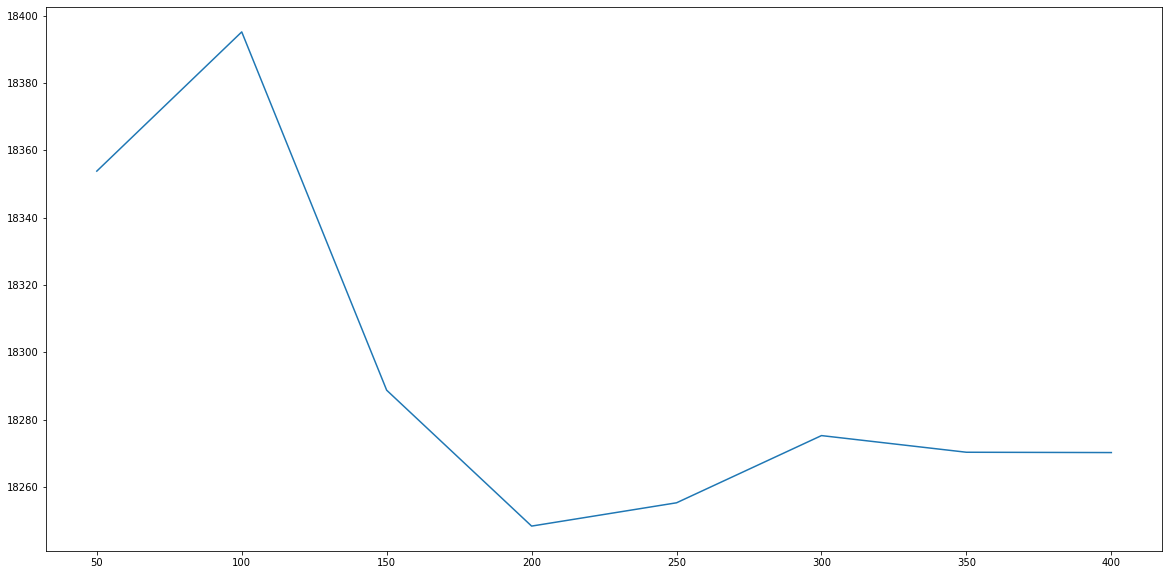

In [51]:
scores_dict['A8']=min(results.values()) # Store the score in the dictioanary

# https://stackoverflow.com/questions/43431347/python-dictionary-plot-matplotlib/43431522
# Thanks to: @tanaka, @LucG
fig = plt.figure(figsize=[20, 10])
plt.plot(list(results.keys()),list(results.values()))

### Create Submission File for approach 8

In [52]:
# Prepare data

# Separate target from predictors
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)
X_test = test_data.copy()

print ("Shape of X: {}".format(X.shape))
print ("Shape of X_test: {}".format(X_test.shape))
print ("Shape of y: {}\n".format(y.shape))

categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and 
                        X[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols

Shape of X: (1460, 79)
Shape of X_test: (1459, 79)
Shape of y: (1460,)



In [53]:
# Define transformers
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [54]:
# Define the Model
model = RandomForestRegressor(n_estimators=200, random_state=0)

In [55]:
# Preprocessing of training data, fit model 
cv_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
cv_X = X[my_cols].copy()
cv_X_test = X_test[my_cols].copy()
cv_pipeline.fit(cv_X, y)

# Preprocessing of validation data, get predictions
preds_a8 = cv_pipeline.predict(cv_X_test)

# Save test predictions to file
save_file(preds_a8)

Submission file is saved


Score for A8 (n_estimators=200) = 15950.53953

In [56]:
submission_dict['A8'] = 15950.53953

# **Lesson 6 - XGBoost**  <a id='Lesson6'></a>

## **Approach 9 (A9):**  <a id='L6A9'></a>
Using Gradient boosting

In [57]:
# Prepare data

# Separate target from predictors
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)


print ("Shape of X: {}".format(X.shape))
print ("Shape of y: {}\n".format(y.shape))


# Get training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
print ("Shape of X_train_full: {}".format(X_train_full.shape))
print ("Shape of X_valid_full: {}".format(X_valid_full.shape))
print ("Shape of y_train: {}".format(y_train.shape))
print ("Shape of y_valid: {}".format(y_valid.shape))


# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols

X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()


# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

print ("\nShape of X_train after encoding: {}".format(X_train.shape))
print ("Shape of y_train after encoding: {}".format(y_train.shape))
print ("Shape of X_valid after encoding: {}".format(X_valid.shape))
print ("Shape of y_valid after encoding: {}".format(y_valid.shape))

Shape of X: (1460, 79)
Shape of y: (1460,)

Shape of X_train_full: (1168, 79)
Shape of X_valid_full: (292, 79)
Shape of y_train: (1168,)
Shape of y_valid: (292,)

Shape of X_train after encoding: (1168, 227)
Shape of y_train after encoding: (1168,)
Shape of X_valid after encoding: (292, 227)
Shape of y_valid after encoding: (292,)


In [58]:
# Train model
my_model = XGBRegressor(random_state=0)
my_model.fit(X_train, y_train)
# Predict
prediction_1 = my_model.predict(X_valid)

# Calculate MAE
scores_dict['A9'] = mean_absolute_error(prediction_1, y_valid) # Store the score in the dictioanary

# print MAE
print("Mean Absolute Error:\n" , scores_dict['A9'])

Mean Absolute Error:
 17662.736729452055


### Create Submission File for approach 9

In [59]:
# Prepare data

# Separate target from predictors
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)
X_test = test_data.copy()

print ("Shape of X: {}".format(X.shape))
print ("Shape of X_test: {}".format(X_test.shape))
print ("Shape of y: {}\n".format(y.shape))


# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and 
                        X[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X = X[my_cols]
X_test = X_test[my_cols]

# One-hot encode the data (to shorten the code, we use pandas)
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)
X, X_test = X.align(X_test, join='left', axis=1)

print ("\nShape of X after encoding: {}".format(X.shape))
print ("Shape of X_test after encodin: {}".format(X_test.shape))


my_model = XGBRegressor(random_state=0)
my_model.fit(X, y)
preds_a9 = my_model.predict(X_test)

# Save test predictions to file
save_file(preds_a9)

Shape of X: (1460, 79)
Shape of X_test: (1459, 79)
Shape of y: (1460,)


Shape of X after encoding: (1460, 232)
Shape of X_test after encodin: (1459, 232)
Submission file is saved


Score for A9 = 16011.84256

In [60]:
submission_dict['A9'] = 16011.84256

## **Approach 10 (A10):**  <a id='L6A10'></a>
Gradient boosting - Early stopping rounds

In [61]:
# Prepare data

# Separate target from predictors
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)


print ("Shape of X: {}".format(X.shape))
print ("Shape of y: {}\n".format(y.shape))


# Get training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
print ("Shape of X_train_full: {}".format(X_train_full.shape))
print ("Shape of X_valid_full: {}".format(X_valid_full.shape))
print ("Shape of y_train: {}".format(y_train.shape))
print ("Shape of y_valid: {}".format(y_valid.shape))


# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols

X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()


# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

print ("\nShape of X_train after encoding: {}".format(X_train.shape))
print ("Shape of y_train after encoding: {}".format(y_train.shape))
print ("Shape of X_valid after encoding: {}".format(X_valid.shape))
print ("Shape of y_valid after encoding: {}".format(y_valid.shape))


Shape of X: (1460, 79)
Shape of y: (1460,)

Shape of X_train_full: (1168, 79)
Shape of X_valid_full: (292, 79)
Shape of y_train: (1168,)
Shape of y_valid: (292,)

Shape of X_train after encoding: (1168, 227)
Shape of y_train after encoding: (1168,)
Shape of X_valid after encoding: (292, 227)
Shape of y_valid after encoding: (292,)


In [62]:
# Define the model
my_model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=2)

# Fit the model
my_model_2.fit(X_train, y_train,
               early_stopping_rounds=5,
               eval_set=[(X_valid, y_valid)],
               verbose=False)
               

# Get predictions
predictions_2 = my_model_2.predict(X_valid)

# Calculate MAE
scores_dict['A10'] = mean_absolute_error(predictions_2, y_valid) # Store the score in the dictioanary

# Uncomment to print MAE
print("Mean Absolute Error:\n" , scores_dict['A10'])

Mean Absolute Error:
 16802.965325342466


### Create Submission File for approach 10

In [63]:
# Prepare data

# Separate target from predictors
y = train_data.SalePrice
X = train_data.drop(['SalePrice'], axis=1)
X_test_full = test_data.copy()


print ("Shape of X: {}".format(X.shape))
print ("Shape of y: {}".format(y.shape))
print ("Shape of X_test_full: {}\n".format(X_test_full.shape))

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
print ("Shape of X_train_full: {}".format(X_train_full.shape))
print ("Shape of X_valid_full: {}".format(X_valid_full.shape))
print ("Shape of y_train: {}".format(y_train.shape))
print ("Shape of y_valid: {}".format(y_valid.shape))

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()


# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

print ("\nShape of X_train after encoding: {}".format(X_train.shape))
print ("Shape of y_train after encoding: {}".format(y_train.shape))
print ("Shape of X_valid after encoding: {}".format(X_valid.shape))
print ("Shape of y_valid after encoding: {}".format(y_valid.shape))
print ("Shape of X_test after encoding: {}".format(X_test.shape))

Shape of X: (1460, 79)
Shape of y: (1460,)
Shape of X_test_full: (1459, 79)

Shape of X_train_full: (1168, 79)
Shape of X_valid_full: (292, 79)
Shape of y_train: (1168,)
Shape of y_valid: (292,)

Shape of X_train after encoding: (1168, 227)
Shape of y_train after encoding: (1168,)
Shape of X_valid after encoding: (292, 227)
Shape of y_valid after encoding: (292,)
Shape of X_test after encoding: (1459, 227)


In [64]:
# Define the model
my_model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=2)

# Fit the model
my_model_2.fit(X_train, y_train,
               early_stopping_rounds=5,
               eval_set=[(X_valid, y_valid)],
               verbose=False)
               

prediction_2 = my_model_2.predict(X_test)

# Save test predictions to file
save_file(prediction_2)


Submission file is saved


Score for A10= 14810.12828

In [65]:
submission_dict['A10'] = 14810.12828

# **Conclusion**  <a id='conclusion'></a>
Below you can see how validation and corresponding actual scores behave for each score.

In [66]:
print(scores_dict)
print(submission_dict)

{'A1': 17837.82570776256, 'A2': 18062.894611872147, 'A3': 18026.217694063926, 'A4': 17837.82570776256, 'A5': 17222.518561643836, 'A6': 17648.417157534244, 'A7': 17648.417157534244, 'A8': 18248.345889801505, 'A9': 17662.736729452055, 'A10': 16802.965325342466}
{'A1': 17688.4249, 'A2': 16546.14937, 'A3': 16423.75248, 'A4': 17688.4249, 'A5': 16004.32251, 'A6': 16073.17499, 'A7': 16073.17499, 'A8': 15950.53953, 'A9': 16011.84256, 'A10': 14810.12828}


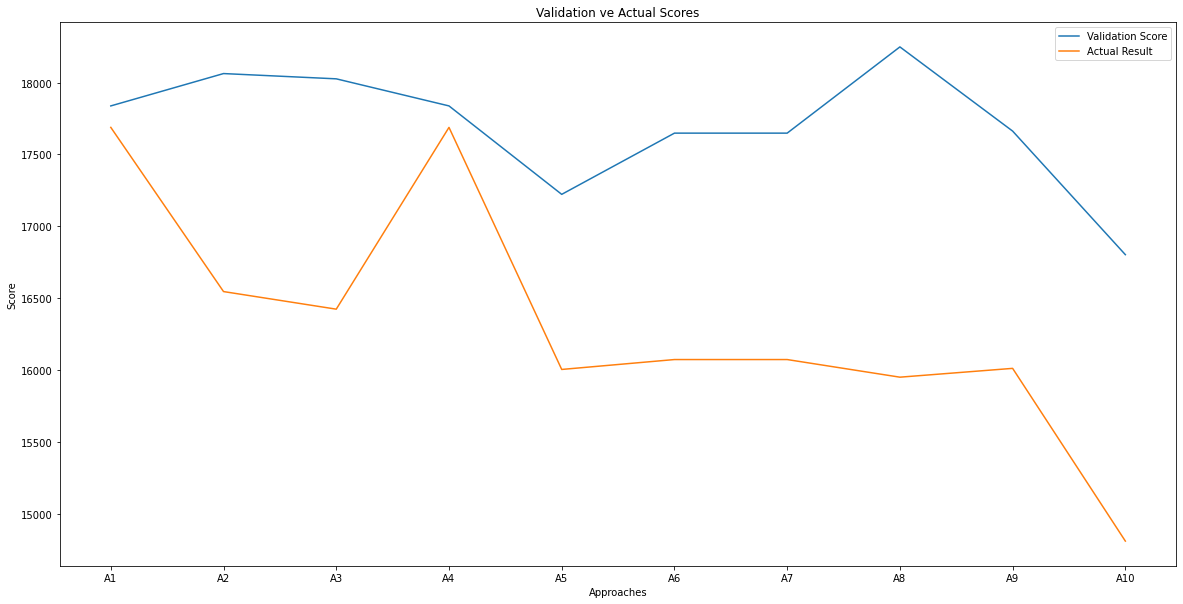

In [67]:
# Plot Validation Score ve Actual Results figure
Y1=[x for x in scores_dict.values()]
Y2=[x for x in submission_dict.values()]

X1=[x for x in scores_dict.keys()]
X2=[x for x in submission_dict.keys()]

fig = plt.figure(figsize=[20, 10])
plt.xlabel('Approaches')
plt.ylabel('Score')
plt.title('Validation ve Actual Scores')
plt.plot(X1,Y1, color='tab:blue')
plt.plot(X2,Y2, color='tab:orange')

plt.legend(["Validation Score", "Actual Result"])

# **References**  <a id='references'></a>
* [@alexisbcook](https://www.kaggle.com/alexisbcook)
* [Kaggle Learn](https://www.kaggle.com/learn/overview)
* [Intermediate Machine Learning Course](https://www.kaggle.com/learn/intermediate-machine-learning)
* [10-simple-hacks-to-speed-up-your-data-analysis - Parul Pandey](https://www.kaggle.com/parulpandey/10-simple-hacks-to-speed-up-your-data-analysis)